In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import itertools

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from datasets import Dataset, DatasetDict, ClassLabel, Value, Features
from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import TFAutoModelForSequenceClassification

from sklearn.preprocessing import StandardScaler

from torch.nn.functional import cross_entropy
import umap

In [4]:
tdf = pd.read_csv('Data\\twitter_training.csv')
vdf = pd.read_csv('Data\\twitter_validation.csv')

In [5]:
tdf

,ID,Topic,Sentiment,Comment
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [7]:
y = 1
for index, row in tdf.iterrows():
    if y >= 2:
        tdf = tdf.drop(index)
    if y == 6:
        y = 1
    else:
        y= y + 1

In [ ]:
tdf = tdf.replace("Irrelevant", "Neutral")

In [27]:
ntdf = pd.DataFrame(columns=["ID", "Topic", "Sentiment", "Comment"])
sx = 0
Pcounter = 0
Negcounter = 0
Nuecounter = 0
for index, row in tdf.iterrows():
    if row["Sentiment"] == "Positive":
        if Pcounter < 500:
            ntdf.loc[sx] = row
            Pcounter = Pcounter + 1
            sx = sx + 1
        else:
            pass
    else:
        pass
    if row["Sentiment"] == "Negative":
        if Negcounter < 500:
            ntdf.loc[sx] = row
            Negcounter = Negcounter + 1
            sx = sx + 1
        else:
            pass
    else:
        pass
    if row["Sentiment"] == "Neutral":
        if Nuecounter < 500:
            ntdf.loc[sx] = row
            Nuecounter = Nuecounter + 1
            sx = sx + 1
        else:
            pass
    else:
        pass


In [ ]:
def Cleaning(x):
    lemmatizer = WordNetLemmatizer()
    x = str(x)
    na = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    naa = []
    for z in na:
        naa.append(lemmatizer.lemmatize(z))
    nnaa = " ".join(naa)
    return nnaa

def RSW(x):
    x = str(x)
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    nt = " ".join(filtered_sentence)
    return nt

#Creating Lem With Stop
for index, row in ntdf.iterrows():
    oa = row["Comment"]
    g = row.name
    ntdf.loc[g, "clean_Comment"] = Cleaning(oa)

#Creating No Lem With out Stop
for index, row in ntdf.iterrows():
    oa = row["Comment"]
    g = row.name
    ntdf.loc[g, "No_Stop_Words_Comment"] = RSW(oa)
#Creating Lem With Out Stop
for index, row in ntdf.iterrows():
    oa = row["Comment"]
    g = row.name
    ns = Cleaning(oa)
    nns = RSW(ns)
    ntdf.loc[g, "No_Stop_Words_Lemmatized_Comment"] = nns
    

In [ ]:
ntdf['Comment'] = ntdf['Comment'].astype(str)
ntdf['clean_Comment'] = ntdf['clean_Comment'].astype(str)
ntdf['No_Stop_Words_Comment'] = ntdf['No_Stop_Words_Comment'].astype(str)
ntdf['No_Stop_Words_Lemmatized_Comment'] = ntdf['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [39]:
ntdf.drop('Topic', axis=1, inplace=True)

In [42]:
ntdf['ID'] = ntdf['ID'].astype(str)
ntdf['No_Stop_Words_Lemmatized_Comment'] = ntdf['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [43]:
X_train, X_test = train_test_split(ntdf, test_size=0.20, random_state=17)
data_dir = Path('data')

X_train['split'] = 'train'
X_test['split'] = 'test'
X = pd.concat([X_train, X_test])
X['path'] = X.apply(lambda x:data_dir.joinpath(x.split, x.Sentiment, x.ID+'.txt'), axis=1)

def save_file(text:str, path: Path):

    if not path.parent.exists():
        path.parent.mkdir(exist_ok=True, parents=True)
    path.write_text(text, encoding='utf-8')

X.apply(lambda x:save_file(x.No_Stop_Words_Lemmatized_Comment, x.path), axis=1)

758     None
192     None
200     None
293     None
832     None
        ... 
64      None
505     None
168     None
162     None
1077    None
Length: 1500, dtype: object

In [4]:
batch_size = 1
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
	'data/train',
    class_names = ['Positive', 'Negative', 'Neutral'],
	batch_size=batch_size,
	validation_split=0.2,
	subset='training',
	seed=seed)

Found 1200 files belonging to 3 classes.
Using 960 files for training.


In [5]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'data/train',
    class_names = ['Positive', 'Negative', 'Neutral'],
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
    )

Found 1200 files belonging to 3 classes.
Using 240 files for validation.


In [6]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'data/test',
    class_names = ['Positive', 'Negative', 'Neutral'],
    batch_size=batch_size)

Found 300 files belonging to 3 classes.


In [7]:
train_list = []
for text, label in raw_train_ds:
  train_list.append({'text': text[0].numpy().decode('utf-8'), 'label': label[0].numpy()})
train_dataset = Dataset.from_list(train_list)

valid_list = []
for text, label in raw_val_ds:
  valid_list.append({'text': text[0].numpy().decode('utf-8'), 'label': label[0].numpy()})
valid_dataset = Dataset.from_list(valid_list)

test_list = []
for text, label in raw_test_ds:
  test_list.append({'text': text[0].numpy().decode('utf-8'), 'label': label[0].numpy()})
test_dataset = Dataset.from_list(test_list)

dataset = DatasetDict({
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 960
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 240
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
})

In [8]:
dataset.set_format(type='pandas')

In [9]:
Labels = {0 : "Positive", 1 : "Negative", 2 : "Neutral"}

In [9]:
train_ds = dataset['train']
train_ds.features
df_new = dataset['train'][:]
df_new.head()

,text,label
0,impatiently waiting play,0
1,greatest protector live amazon jungle,2
2,disappointment,1
3,really enjoying black ops cold war something m...,2
4,love big man suit armor pin wall,0


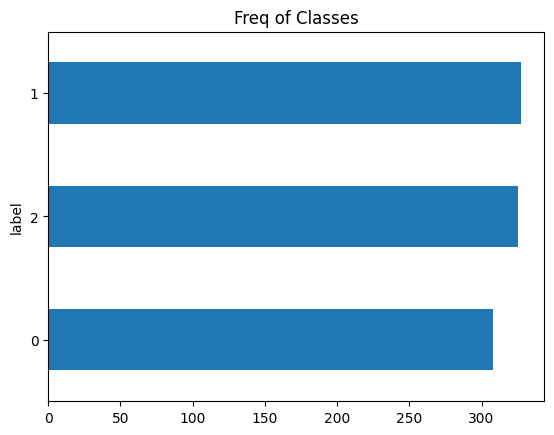

In [10]:
df_new['label'].value_counts(ascending=True).plot.barh()
plt.title('Freq of Classes')
plt.show()

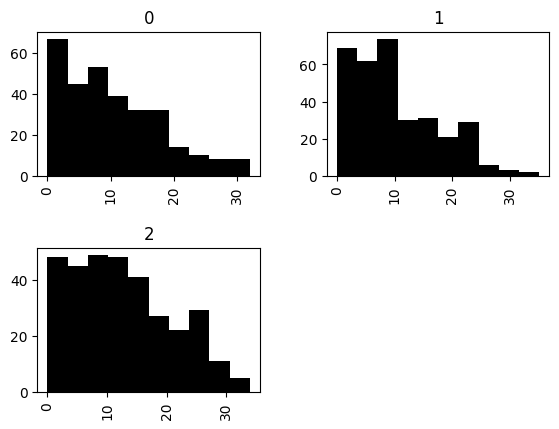

In [11]:
df_new['Words Per Document'] = df_new['text'].str.split().apply(len)
df_new.hist('Words Per Document', 'label', color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [12]:
dataset.reset_format()

In [13]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=tokenizer.model_max_length)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 960
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 240
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [14]:
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3, ignore_mismatched_sizes=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [15]:
def extract_hidden_states(batch):
    batch = {k: v for k, v in batch.items() if k in tokenizer.model_input_names}
    outputs = model(**batch, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    last_hidden_state = hidden_states[-1]
    return {"hidden_state": last_hidden_state[:, 0].numpy()}

In [16]:
print(tokenized_datasets['test']['label'])

[0, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 1, 1, 0, 0, 2, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 0, 1, 2, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2]


In [17]:
tokenized_datasets.set_format("tensorflow", columns=["input_ids", "attention_mask", "label"])
dataset_hidden = tokenized_datasets.map(extract_hidden_states, batched=True, batch_size=5)

c:\Users\ruthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

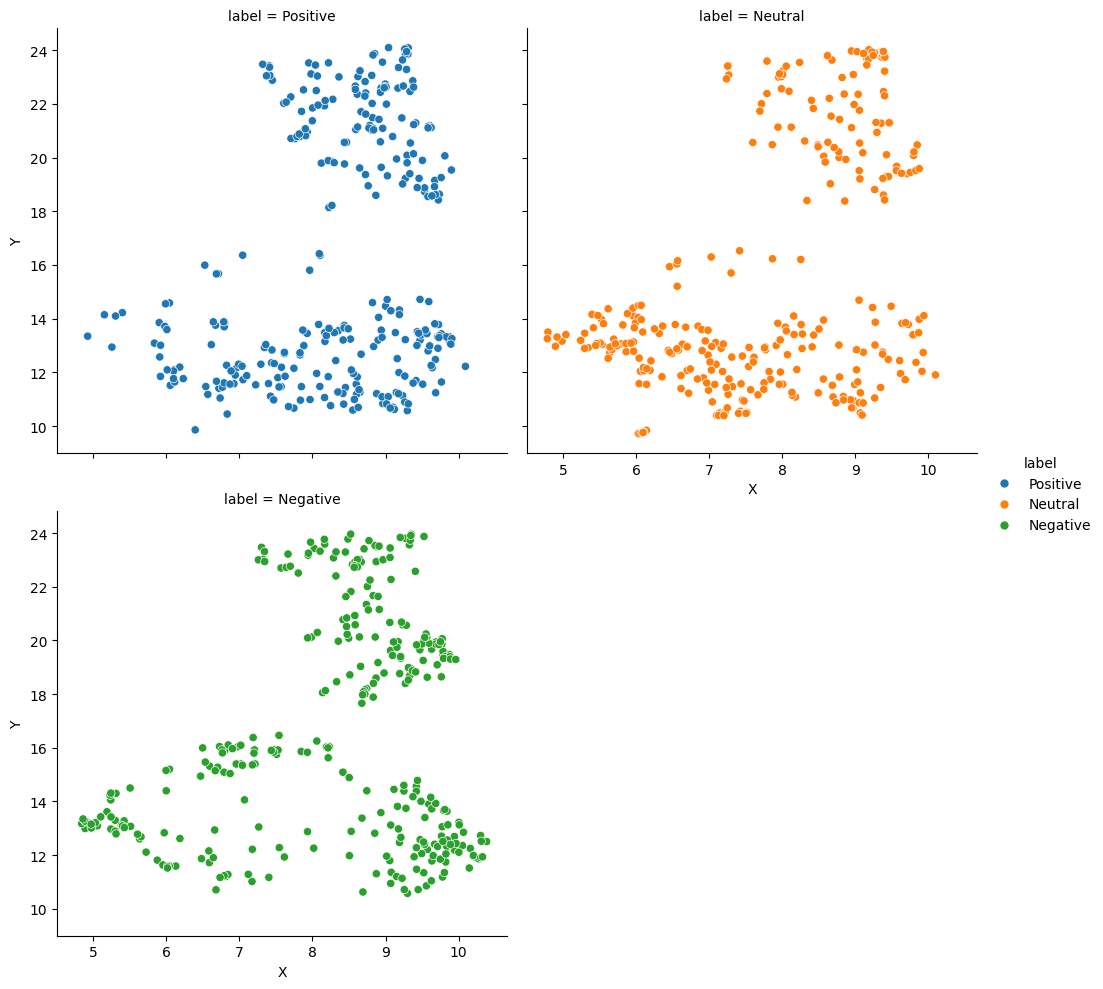

In [20]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])

reducer = umap.UMAP(metric='cosine', n_components=2)
X_scaled = StandardScaler().fit_transform(X_train)
embedding = reducer.fit_transform(X_scaled)
df_emb = pd.DataFrame(embedding, columns=['X', 'Y'])
df_emb["label"] = df_new['label']
df_emb["label"] = df_emb["label"].replace(0, "Positive")
df_emb["label"] = df_emb["label"].replace(1, "Negative")
df_emb["label"] = df_emb["label"].replace(2, "Neutral")
df_emb.head()
sns.relplot(data=df_emb, x='X', y='Y', hue='label', col="label", kind='scatter', col_wrap=2)
plt.show()

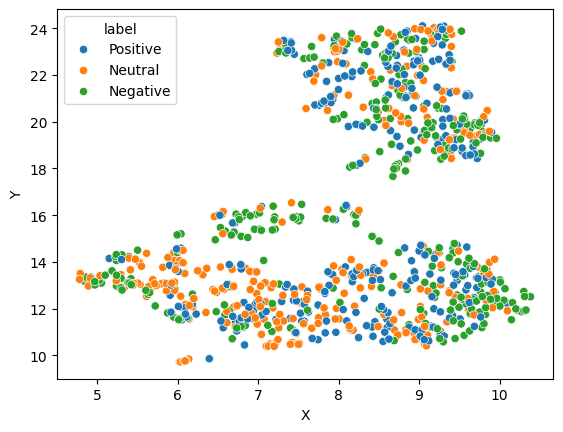

In [21]:
sns.scatterplot(data=df_emb, x='X', y='Y', hue='label')
plt.show()

In [21]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5875

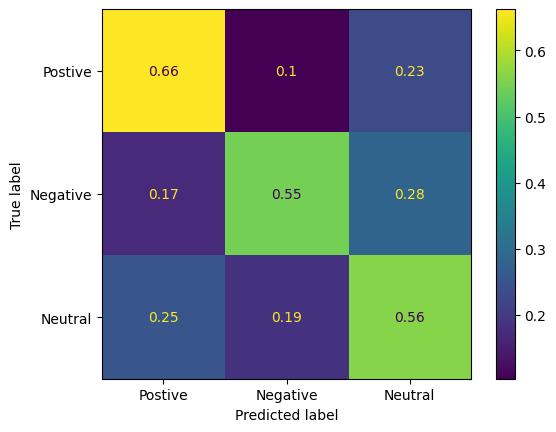

In [22]:
labels = df_new['label']

y_preds = lr_clf.predict(X_valid)

metrics.ConfusionMatrixDisplay.from_predictions(y_preds,y_valid,normalize='true',display_labels=["Postive", "Negative", "Neutral"])
plt.show()

In [23]:
print(f'Accuracy: {lr_clf.score(X_test, y_test)}')
print(f'Recall: {metrics.recall_score(y_test, lr_clf.predict(X_test), average="macro")}')
print(f'Precision: {metrics.precision_score(y_test, lr_clf.predict(X_test), average="macro")}')
print(f'F1: {metrics.f1_score(y_test, lr_clf.predict(X_test), average="macro")}')

Accuracy: 0.6166666666666667
Recall: 0.6125702782902674
Precision: 0.6125975473801561
F1: 0.6125149815650537


In [24]:
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [25]:
tokenizer_columns = tokenizer.model_input_names
batch_size = 5
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = tokenized_datasets["valid"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)
tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

c:\Users\ruthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=tf.metrics.SparseCategoricalAccuracy())

model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=5)

Epoch 1/5

192/192 [==============================] - 189s 947ms/step - loss: 1.0037 - sparse_categorical_accuracy: 0.4958 - val_loss: 0.8590 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/5
192/192 [==============================] - 180s 938ms/step - loss: 0.7043 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.8847 - val_sparse_categorical_accuracy: 0.5667
Epoch 3/5
192/192 [==============================] - 179s 934ms/step - loss: 0.4268 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.9105 - val_sparse_categorical_accuracy: 0.6458
Epoch 4/5
192/192 [==============================] - 179s 932ms/step - loss: 0.2476 - sparse_categorical_accuracy: 0.9208 - val_loss: 1.2866 - val_sparse_categorical_accuracy: 0.6333
Epoch 5/5
192/192 [==============================] - 180s 935ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.9510 - val_loss: 1.4896 - val_sparse_categorical_accuracy: 0.5917


In [32]:
model.save('model_directory')


INFO:tensorflow:Assets written to: model_directory\assets


INFO:tensorflow:Assets written to: model_directory\assets


In [37]:
loaded_model = tf.saved_model.load('model_directory')

In [27]:
print(f'Accuracy: {model.evaluate(tf_test_dataset)[1]}')
print(f'Recall: {metrics.recall_score(y_test, np.argmax(model.predict(tf_test_dataset)[0], axis=1), average="macro")}')
print(f'Precision: {metrics.precision_score(y_test, np.argmax(model.predict(tf_test_dataset)[0], axis=1), average="macro")}')
print(f'F1: {metrics.f1_score(y_test, np.argmax(model.predict(tf_test_dataset)[0], axis=1), average="macro")}')

60/60 [==============================] - 14s 241ms/step - loss: 1.4786 - sparse_categorical_accuracy: 0.6233
Accuracy: 0.6233333349227905
60/60 [==============================] - 15s 237ms/step
Recall: 0.6029294242977211
60/60 [==============================] - 14s 237ms/step
Precision: 0.6360102950264065
60/60 [==============================] - 14s 237ms/step
F1: 0.5739858906525573


60/60 [==============================] - 15s 242ms/step


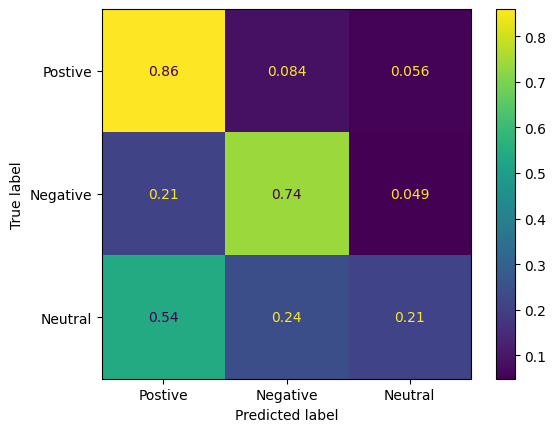

In [28]:
y_pred = np.argmax(model.predict(tf_test_dataset)['logits'], axis=1)

y_true = np.array(dataset_hidden["test"]["label"])

labels = ["Postive", "Negative", "Neutral"]
y_true = y_true.astype(int)

metrics.ConfusionMatrixDisplay.from_predictions(y_true,
                                                y_pred,
                                                normalize='true',
                                                display_labels=labels)
plt.show()

In [46]:
def predict_proba(text_list, model, tokenizer):  
    encodings = tokenizer(text_list, 
                          max_length=tokenizer.model_max_length, 
                          truncation=True, 
                          padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    preds = model.predict(dataset.batch(1)).logits  
    res = tf.nn.softmax(preds, axis=1).numpy() 
    newlist = []
    for x in res:
        if x[0] > x[1] and x[0] > x[2]:
            newlist.append("Positive")
        elif x[1] > x[0] and x[1] > x[2]:
            newlist.append("Negative")
        elif x[2] > x[0] and x[2] > x[1]:
            newlist.append("Neutral")     
    return newlist

In [50]:
strings_list = ["Finally played Rainbow Six Siege for the first time... I have to admit, I prefer it over pulling my hair out in CSGO any day.",
  "Just finished Assassins Creed Odyssey through @Shadow_Official @Shadow_NA from the beginning to the end. Thanks for the amazing gaming experience on your service"]

predict_proba(strings_list, model, tokenizer)

2/2 [==============================] - 0s 12ms/step


['Positive', 'Positive']

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [41]:
infer = loaded_model.signatures['serving_default']